In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt

import features
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load features and labels

In [17]:
data_path = '../data/'
# Load all users' work days
with open(data_path+'usr_work_days.pkl', 'rb') as f:
    USR_WORK_DAYS = pickle.load(f)


#label_path = '../data/03996723-2411-4167-b14b-eb11dfc33124/'
usr_id = '03996723-2411-4167-b14b-eb11dfc33124'
usr_path = data_path + usr_id + '/'

WIN_SIZE = 2 # second
OVERLAP = 0 # Zero overlapping between sliding windowss

feature_mat = list()
labels = list()

for day in USR_WORK_DAYS[usr_id]:
    print('Creating features on '+ day)
    data_fn = usr_path+'data'+day+'.npz'
    data = np.load(data_fn)
    ts = data['ts']
    offset = data['offset']
    accel = data['accel']
    gyro = data['gyro']
    step_cnt = data['step_cnt']
    act_type = data['act_type']
    lbl = data['labels']
    
    win_len = int(utils.INTERP_FREQ * WIN_SIZE) 
    overlap_len = int(utils.INTERP_FREQ * OVERLAP * WIN_SIZE)
    accel_x_wins = utils.generate_wins(accel[:, 0], win_len, overlap_len)
    accel_y_wins = utils.generate_wins(accel[:, 1], win_len, overlap_len)
    accel_z_wins = utils.generate_wins(accel[:, 2], win_len, overlap_len)
    
    gyro_x_wins = utils.generate_wins(gyro[:, 0], win_len, overlap_len)
    gyro_y_wins = utils.generate_wins(gyro[:, 1], win_len, overlap_len)
    gyro_z_wins = utils.generate_wins(gyro[:, 2], win_len, overlap_len)
    
    step_cnt_wins = utils.generate_wins(step_cnt[:, 0], win_len, overlap_len)
    act_type_wins = utils.generate_wins(act_type[:, 0], win_len, overlap_len)
    
    ts_wins = utils.generate_wins(ts, win_len, overlap_len)
    offset_wins = utils.generate_wins(ts, win_len, overlap_len)

    ts_features = list()
    for ts_win, offset_win in zip(ts_wins, offset_wins):
        ts_features.append([features.is_weekday(ts_win[0], offset_win[0]), features.local_hour(ts_win[0], offset_win[0])])
    ts_features = np.array(ts_features)
    
    label_wins = utils.generate_wins(lbl, win_len, overlap_len)
    

    feature_mat.append(np.hstack([accel_x_wins, accel_y_wins, accel_z_wins,
                               gyro_x_wins, gyro_y_wins, gyro_z_wins,
                               step_cnt_wins, act_type_wins, ts_features]))
    
    labels.append(label_wins)
feature_mat = np.vstack(feature_mat)
labels = np.vstack(labels)
#labels = stats.mode(labels, axis=1)[0][:, 0]

print('Feature matrix shape:', feature_mat.shape)
print('Label matrix shape:', labels.shape)

Creating features on 20171111
Creating features on 20171112
Creating features on 20171113
Creating features on 20171114
Creating features on 20171115
Creating features on 20171116
Creating features on 20171120
Creating features on 20171121
Creating features on 20171122
Creating features on 20171127
Creating features on 20171128
Creating features on 20171129
Creating features on 20171130
Creating features on 20171204
Creating features on 20171205
Creating features on 20171206
Creating features on 20171207
Creating features on 20171208
Creating features on 20171212
Creating features on 20171213
Creating features on 20171214
Creating features on 20171215
Creating features on 20171216
Creating features on 20171218
Creating features on 20171219
Creating features on 20171220
Creating features on 20171221
Creating features on 20171222
Creating features on 20180102
Creating features on 20180103
Creating features on 20180104
Creating features on 20180105
Creating features on 20180106
Creating f

In [6]:
unique, counts = np.unique(stats.mode(labels, axis=1)[0][:, 0], return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 499358, 1.0: 144207}


# Balance classes and normailze feature matrix

In [7]:
win_labels = stats.mode(labels, axis=1)[0][:, 0]
zero_indices = np.where(win_labels==0)[0]
one_indices = np.where(win_labels==1)[0]

zero_indices = np.random.choice(zero_indices, size=one_indices.shape[0], replace=False)

indices = np.hstack((zero_indices, one_indices))

np.random.shuffle(indices)

new_labels = win_labels[indices]
#new_features = normalize(features[indices])
new_features = feature_mat[indices]
print('Feature matrix shape:', new_features.shape)
print('Label matrix shape:', new_labels.shape)

Feature matrix shape: (288414, 322)
Label matrix shape: (288414,)


# Create train set, validation set, and test set

In [8]:
num_classes = 2
split_idx = int(new_features.shape[0] * 0.80)

X_train = new_features[:split_idx]
Y_train = new_labels[:split_idx]

X_test = new_features[split_idx:]
Y_test = new_labels[split_idx:]

Y_train = keras.utils.to_categorical(Y_train, num_classes)
#Y_val = keras.utils.to_categorical(Y_val, num_classes)

print('train data shape:', X_train.shape)
print('train label shape:', Y_train.shape)
#print('val data shape:', X_val.shape)
#print('val label shape:', Y_val.shape)
print('test data shape:', X_test.shape)
print('test label shape:', Y_test.shape)

train data shape: (230731, 322)
train label shape: (230731, 2)
test data shape: (57683, 322)
test label shape: (57683,)


# Create MLP classifier

In [9]:
p = 0.3
model = keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(keras.layers.Dense(units=256, 
                             activation='relu', 
                             input_dim=X_train.shape[1]))
model.add(keras.layers.Dense(units=128, 
                             activation='relu', 
                             input_dim=X_train.shape[1]))
# Add another:
model.add(keras.layers.Dropout(p))
model.add(keras.layers.Dense(units=64, activation='relu',
                             kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(p))
model.add(keras.layers.Dense(units=64, activation='relu'))

# Add a softmax layer with 10 output units:
model.add(keras.layers.Dense(units=2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               82688     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total para

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


# Train the model

In [10]:
epochs = 100
batch_size = 512
data_path = '.'
data_file = '/DNN_Model-10Second'


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])


checkpointer = keras.callbacks.ModelCheckpoint(filepath=data_path+data_file, 
                                               verbose=1,
                                               monitor='val_acc',
                                               save_best_only=True, 
                                               save_weights_only=False)

callbacks_list = [checkpointer]

H = model.fit(X_train, 
              Y_train, 
              batch_size=batch_size, 
              epochs=epochs, verbose=1, 
              shuffle=True, 
              validation_split=0.2,
              callbacks=callbacks_list)
#validation_data=(X_val, Y_val),

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Train on 184584 samples, validate on 46147 samples
Epoch 1/100
184584/184584 [==============================] - 3s 14us/step - loss: 0.6441 - acc: 0.6907 - val_loss: 0.5590 - val_acc: 0.7320

Epoch 00001: val_acc improved from -inf to 0.73203, saving model to ./DNN_Model-10Second
Epoch 2/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.5543 - acc: 0.7349 - val_loss: 0.5290 - val_acc: 0.7466

Epoch 00002: val_acc improved from 0.73203 to 0.74664, saving model to ./DNN_Model-10Second
Epoch 3/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.5174 - acc: 0.7552 - val_loss: 0.4969 - val_acc: 0.7730

Epoch 00003: val_acc improved from 0.74664 to 0.77303, saving model to ./DNN_Model-10Second
Epoch 4/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4921 - acc: 0.7692 - val_loss: 0.4684 - val_acc: 0.7814

Epoch 00004: val_acc improved from 0.77303 to 0.78144, saving model to ./DNN_Model-10Second
Epoch 5/100
184584/1

184584/184584 [==============================] - 2s 11us/step - loss: 0.3590 - acc: 0.8428 - val_loss: 0.3608 - val_acc: 0.8457

Epoch 00039: val_acc did not improve from 0.85223
Epoch 40/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.3612 - acc: 0.8418 - val_loss: 0.3647 - val_acc: 0.8411

Epoch 00040: val_acc did not improve from 0.85223
Epoch 41/100
184584/184584 [==============================] - 2s 11us/step - loss: 0.3593 - acc: 0.8426 - val_loss: 0.3618 - val_acc: 0.8437

Epoch 00041: val_acc did not improve from 0.85223
Epoch 42/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.3583 - acc: 0.8436 - val_loss: 0.3529 - val_acc: 0.8494

Epoch 00042: val_acc did not improve from 0.85223
Epoch 43/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.3566 - acc: 0.8444 - val_loss: 0.3696 - val_acc: 0.8345

Epoch 00043: val_acc did not improve from 0.85223
Epoch 44/100
184584/184584 [=========================

184584/184584 [==============================] - 2s 12us/step - loss: 0.3349 - acc: 0.8559 - val_loss: 0.3496 - val_acc: 0.8515

Epoch 00080: val_acc did not improve from 0.86235
Epoch 81/100
184584/184584 [==============================] - 2s 11us/step - loss: 0.3312 - acc: 0.8574 - val_loss: 0.3384 - val_acc: 0.8576

Epoch 00081: val_acc did not improve from 0.86235
Epoch 82/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.3327 - acc: 0.8568 - val_loss: 0.3520 - val_acc: 0.8544

Epoch 00082: val_acc did not improve from 0.86235
Epoch 83/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.3322 - acc: 0.8573 - val_loss: 0.3359 - val_acc: 0.8632

Epoch 00083: val_acc improved from 0.86235 to 0.86315, saving model to ./DNN_Model-10Second
Epoch 84/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.3301 - acc: 0.8583 - val_loss: 0.3360 - val_acc: 0.8632

Epoch 00084: val_acc improved from 0.86315 to 0.86322, saving

# Plot training accuracy vs testing accuracy

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


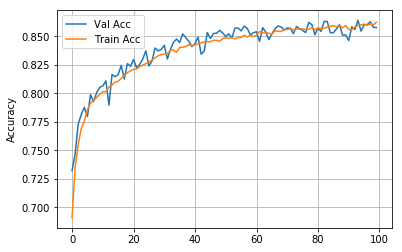

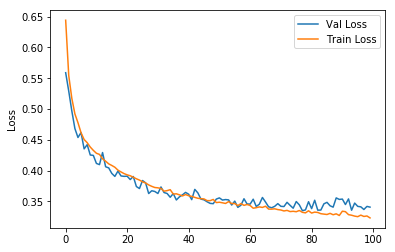

In [11]:
print(H.history.keys())

val_acc=H.history['val_acc']
acc = H.history['acc']

val_loss=H.history['val_loss']
loss = H.history['loss']


#fig= plt.figure(figsize=(15,10))
plt.plot(val_acc,label='Val Acc')
plt.plot(acc,label='Train Acc')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


#fig= plt.figure(figsize=(15,10))
plt.plot(val_loss,label='Val Loss')
plt.plot(loss,label='Train Loss')

plt.ylabel('Loss')
plt.legend()
plt.show()

# Print important window-wise metrics

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Confusion Matrix:
 [[22115  6519]
 [ 1746 27303]]
Accuracy: 0.8567168836572301
F1 score: 0.8685403445149592


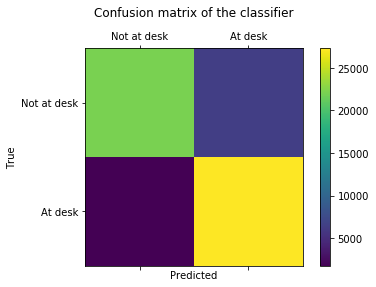

In [12]:
y_pred = np.argmax(model.predict(X_test), axis=1)

y_true = Y_test
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print('Confusion Matrix:\n', cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print('F1 score:', f1_score(y_true, y_pred))

class_labels = ['Not at desk', 'At desk']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier\n')
fig.colorbar(cax)
ax.set_xticklabels([''] + class_labels)
ax.set_yticklabels([''] + class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print important element-wise metrics

In [13]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred = np.reshape(y_pred, (-1,1))
y_pred = np.repeat(y_pred, 40, axis=1)
y_pred = np.ravel(y_pred)

y_true = np.ravel(labels[indices][split_idx:])

cm = confusion_matrix(y_true, y_pred)

[[ 885125  264926]
 [  69315 1087954]]
0.8551388624031344
0.8668441594502956


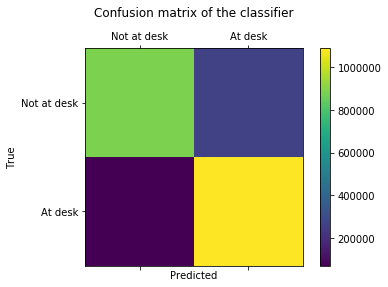

In [16]:
print(cm)
print(accuracy_score(y_true, y_pred))
print(f1_score(y_true, y_pred))

class_labels = ['Not at desk', 'At desk']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier\n')
fig.colorbar(cax)
ax.set_xticklabels([''] + class_labels)
ax.set_yticklabels([''] + class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [15]:
print(y_pred.shape)
print(y_true.shape)

(2307320,)
(2307320,)
